# 验证2-带有一个隐藏层的平面数据分类
--------
## 介绍

在本练习中，我们将建立一个神经网络，它具有一个隐藏层，你可以与练习1中的模型进行对比学习。

我们会讲到以下的知识：

- 构建具有单隐藏层的2类分类神经网络。
- 使用具有非线性激活功能激活函数，例如tanh。
- 计算交叉熵损失（损失函数）。
- 实现向前和向后传播。

在开始练习前，需要**介绍如下的文件**：

- testCases.py -提供了一些测试示例来评估函数的正确性
- planar_utils.py  -提供了在这个练习中使用的各种功能函数，例如sigmoid函数、数据加载函数、绘图函数


在整个练习中，涉及如下的**必做作业**：

| 作业 | 分值 |
|--|--|
|[初始化模型参数](#1)| 10分|
|[实现前向传播](#2)|20分|
|[实现代价函数](#3)|15分|
|[搭建后向传播函数](#4)|20分|
|[实现参数更新函数](#5)|15分|
|[搭建并训练神经网络模型](#6)|20分|


## 1 数据加载和查看
在开始之前，我们需要导入一些会用到的python库文件。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline 

np.random.seed(1) #设置一个固定的随机种子，以保证接下来的步骤中我们的结果是一致的。


接下来，通过调用`planar_utils.py`文件中的`load_planar_dataset()`函数来查看要使用的数据集。

下面的代码会将花的图案的二分类数据集加载到变量`X`和`Y`中。
并对数据进行可视化展示。

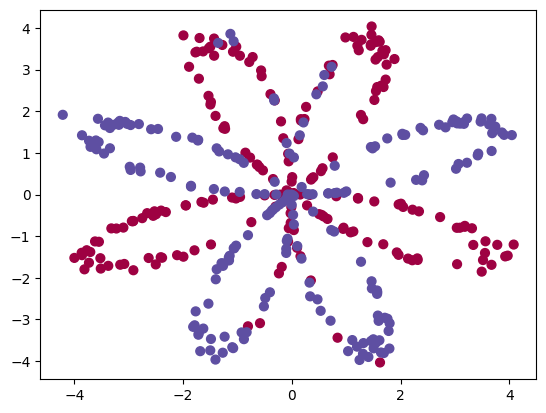

In [2]:
X, Y = load_planar_dataset()
plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral) #绘制散点图

数据看起来像一朵花，其中`y=0`代表红色点，`y=1`代表蓝色点。在本次练习中，你的任务就是建立一个模型来拟合这些数据。现在，我们已经定义了以下变量：
- X： numpy矩阵，包含这些数据点的数值
- Y： numpy矩阵，对应X的标签（值为0-红色，值为1-蓝色）

接下来，看下变量的详细信息：

In [4]:
shape_X = X.shape
shape_Y = Y.shape
m = Y.shape[1] #训练集的数量

print ("X的维度为: " + str(shape_X))
print ("Y的维度为: " + str(shape_Y))
print ("数据集里面的数据有：" + str(m) + " 个")

X的维度为: (2, 400)
Y的维度为: (1, 400)
数据集里面的数据有：400 个


## 2 查看简单Logistic回归的分类效果
在构建完整的神经网络之前，先让我们看看逻辑回归在这个问题上的表现如何。

我们可以使用sklearn的内置函数来做到这一点，运行下面的代码来训练数据集上的逻辑回归分类器，并将分类结果进行可视化，计算分类的准确率。

逻辑回归的准确性： 47 % (正确标记的数据点所占的百分比)


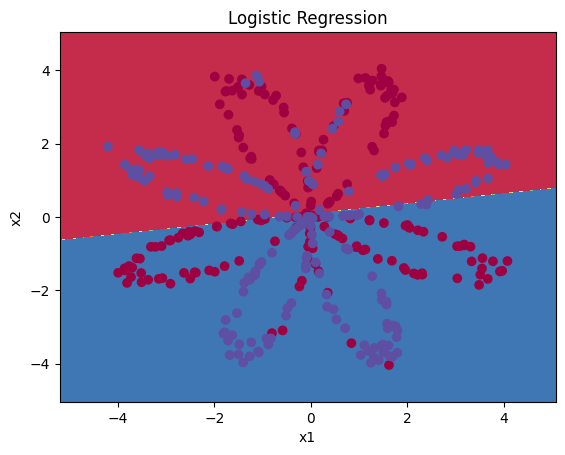

In [6]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T,Y.ravel())
plot_decision_boundary(lambda x: clf.predict(x), X, Y.ravel()) #绘制决策边界
plt.title("Logistic Regression") #图标题
LR_predictions  = clf.predict(X.T) #预测结果
print ("逻辑回归的准确性： %d " % float((np.dot(Y, LR_predictions) + 
        np.dot(1 - Y,1 - LR_predictions)) / float(Y.size) * 100) +
       "% " + "(正确标记的数据点所占的百分比)")

我们看到简单逻辑回归分类器的准确率为47%，这个结果是由于数据集不是线性可分的，因此逻辑回归的效果并不好。接着，我们开始构建神经网络，并查看神经网络下的分类效果。

## 3 搭建神经网络模型

在本练习中，你要搭建的神经网络模型结构如下图所示。

![](2-1.png)
该模型为单隐层神经网络，且隐藏层的单元个数为4。
对于$x^{(i)}$而言，其前向传播的计算过程如下：

$$ z^{[1](i)} = W^{[1]}x^{(i)} + b^{[1](i)}  $$
$$ a^{[1](i)} = tanh(z^{[1](i)}) $$
$$ z^{[2](i)} = W^{[2]}a^{[1](i)} + b^{[2](i)}  $$
$$ \hat{y}^{(i)} = a^{[2](i)} = \sigma(z^{[2](i)}) $$

其中，$\sigma$为sigmoid函数，且计算出所有示例的预测结果就可以按如下公式计算代价$J$：

$$ J = - \frac{1}{m} \sum_{i=0}^M (y^{(i)}log(a^{[2](i)})+(1-y^{(i)})log(1-a^{[2](i)})) $$

因此，构建神经网络的一般方法是： 
1. 定义神经网络结构（输入单元的数量，隐藏单元的数量等）。 
2. 初始化模型的参数 
3. 循环：
    
    - 实施前向传播
    - 计算损失
    - 实现向后传播
    - 更新参数（梯度下降）

我们要它们合并到一个nn_model() 函数中，当我们构建好了nn_model（）并学习了正确的参数，我们就可以预测新的数据。

### 3.1 初始化模型参数<span id='1'></span>
在构建之前，我们要先把神经网络的结构给定义好：

- n_x: 输入层的数量，等同于数据集X的数量
- n_h: 隐藏层的数量（这里设置为4）
- n_y: 输出层的数量，等同于数据集Y的数量

你需要**定义layer_sizes()函数，用于初始定义神经网络模型结构参数**。

**要点**：
- 定义layer_sizes()函数，参数列表及返回值如函数说明所示。
- 按上述要求进行定义，代码测试结果中输入层和输出层的节点数量应依次为5,2。

In [7]:
def layer_sizes(X , Y):
    """
    参数：
     X - 输入数据集,维度为（输入的数量，训练/测试的数量）
     Y - 标签，维度为（输出的数量，训练/测试数量）
    
    返回：
     n_x - 输入层的数量
     n_h - 隐藏层的数量
     n_y - 输出层的数量
    """
    n_x = X.shape[0] #输入层
    n_h = 4 #，隐藏层，硬编码为4
    n_y = Y.shape[0] #输出层
    
    return n_x, n_h, n_y


In [8]:
#测试layer_sizes
print("=========================测试layer_sizes=========================")
X_asses , Y_asses = layer_sizes_test_case()
(n_x,n_h,n_y) =  layer_sizes(X_asses,Y_asses)
print("输入层的节点数量为: n_x = " + str(n_x))
print("隐藏层的节点数量为: n_h = " + str(n_h))
print("输出层的节点数量为: n_y = " + str(n_y))

=========================测试layer_sizes=========================
输入层的节点数量为: n_x = 5
隐藏层的节点数量为: n_h = 4
输出层的节点数量为: n_y = 2


接着，你需要**补全函数initialize_parameters()，将w1,w2,b1,b2使用以下合适的方法进行初始化，并确保其形状满足要求**。

要确保我们的参数大小合适，如果需要的话，请参考上面的神经网络图。
我们将会用随机值初始化权重矩阵。
```python
np.random.randn(a，b)* 0.01 #来随机初始化一个维度为(a，b)的矩阵
```
将偏向量初始化为零。
```python
np.zeros((a，b)) #用零初始化矩阵(a，b)
```

预期的测试结果为：
```shell
W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]
```

In [9]:
def initialize_parameters( n_x , n_h ,n_y):
    """
    参数：
        n_x - 输入层节点的数量
        n_h - 隐藏层节点的数量
        n_y - 输出层节点的数量
    
    返回：
        parameters - 包含参数的字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）

    """
    np.random.seed(2) #指定一个随机种子，以便你的输出与我们的一样。
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    #使用断言确保我的数据格式是正确的
    assert(W1.shape == ( n_h , n_x ))
    assert(b1.shape == ( n_h , 1 ))
    assert(W2.shape == ( n_y , n_h ))
    assert(b2.shape == ( n_y , 1 ))
    
    parameters = {"W1" : W1,
	              "b1" : b1,
	              "W2" : W2,
	              "b2" : b2 }
    
    return parameters

In [10]:
#测试initialize_parameters
print("=========================测试initialize_parameters=========================")    
n_x , n_h , n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x , n_h , n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试initialize_parameters=========================
W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


### 3.2 前向传播计算神经网络层参数<span id='2'></span>
回顾之前的计算过程，你需要**实现前向传播函数forward_propagation()**，其中激活函数可以用`sigmoid()`函数也可以使用`np.tanh()`函数。
具体的实现步骤如下：

1. 使用字典类型的`parameters`（`initialize_parameters()`的输出）检索每个参数
2. 实现前向传播, 计算$Z^{[1]}, A^{[1]}, Z^{[2]},A^{[2]}$ (训练集里面所有例子的预测向量)
3. 反向传播所需的值存储在“cache”中，`cache`将作为反向传播函数的输入。


**要点**：
- 依据上述实现步骤对函数进行补全，确保数据形状符合要求
- 代码测试结果预期为：
```shell 
-0.0004997557777419913 -0.0004969633532317802 0.0004381874509591466 0.500109546852431
```

In [11]:
def forward_propagation( X , parameters ):
    """
    参数：
         X - 维度为（n_x，m）的输入数据。
         parameters - 初始化函数（initialize_parameters）的输出
    
    返回：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型变量
     """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    #前向传播计算A2
    Z1 = np.dot(W1 , X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2 , A1) + b2
    A2 = sigmoid(Z2)
    #使用断言确保我的数据格式是正确的
    assert(A2.shape == (1,X.shape[1]))
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [12]:
#测试forward_propagation
print("=========================测试forward_propagation=========================") 
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)
print(np.mean(cache["Z1"]), np.mean(cache["A1"]), np.mean(cache["Z2"]), np.mean(cache["A2"]))

=========================测试forward_propagation=========================
-0.0004997557777419913 -0.000496963353231779 0.00043818745095914653 0.500109546852431


### 3.3 实现代价的计算函数<span id='3'></span>
我们已经知道，计算代价的公式如下：

$$ J = - \frac{1}{m} \sum_{i=0}^M (y^{(i)}log(a^{[2](i)})+(1-y^{(i)})log(1-a^{[2](i)})) $$

其中交叉熵损失的计算在python中可以使用向量化来进行实现：
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)   
```
当然，你也可以使用`np.multiply()`然后使用`np.sum()`或者直接使用`np.dot()`
现在你需要**构建计算成本的函数compute_cost()**。

**要点**：
- 按照上述公式补全函数定义
- 预期的测试结果应为
```shell
cost = 0.6929198937761266
```

In [13]:
def compute_cost(A2,Y,parameters):
    """
    计算方程（6）中给出的交叉熵成本，
    
    参数：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         Y - "True"标签向量,维度为（1，数量）
         parameters - 一个包含W1，B1，W2和B2的字典类型的变量
    
    返回：
         成本 - 交叉熵成本给出方程（13）
    """
    
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    #计算成本
    logprobs = logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    cost = float(np.squeeze(cost))
    
    assert(isinstance(cost,float))
    
    return cost

In [14]:
#测试compute_cost
print("=========================测试compute_cost=========================") 
A2 , Y_assess , parameters = compute_cost_test_case()
print("cost = " + str(compute_cost(A2,Y_assess,parameters)))

=========================测试compute_cost=========================
cost = 0.6929198937761266


### 3.4 反向传播计算梯度<span id='4'></span>

使用前向传播期间计算的参数字典cache，现在可以利用它实现反向传播。
反向传播是计算梯度的过程，其向量化的实现步骤如下：

$dZ^{[2]} = A^{[2]} -Y$

$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]^T} $

$db^{[2]} = \frac{1}{m} np.sum(dZ^{[2]},axis=1,keepdims=True)$

$dZ^{[1]} = W^{[2]^T}dZ^{[2]}*g^{[1]\prime}(Z^{[1]})$

$dW^{[1]} = \frac{1}{m} dZ^{[1]}X^T$

$db^{[1]} = \frac{1}{m} np.sum(dZ^{[1]},axis=1,keepdims=True)$


其中，为了计算$dZ^{[1]}$，需要计算$g^{[1]\prime}(Z^{[1]})$。

其中`g`代表`tanh()`激活函数，如果$a=g^{[1]}(z)$，那么$g^{[1]\prime}(z) = 1 -a^2$。
因此代码实现时可以使用`(1-np.power(A1,2))`来计算$g^{[1]\prime}(Z^{[1]})$。

接下来，你需要**实现函数backward_propagation()**。

**要点**：
- 按照上述实现步骤对函数进行实现
- 测试结果预期应为：
```shell
dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]
```

In [15]:
def backward_propagation(parameters,cache,X,Y):
    """
    使用上述说明搭建反向传播函数。
    
    参数：
     parameters - 包含我们的参数的一个字典类型的变量。
     cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型的变量。
     X - 输入数据，维度为（2，数量）
     Y - “True”标签，维度为（1，数量）
    
    返回：
     grads - 包含W和b的导数一个字典类型的变量。
    """
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2 }
    
    return grads

In [16]:
#测试backward_propagation
print("=========================测试backward_propagation=========================")
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

=========================测试backward_propagation=========================
dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


### 3.5 使用梯度更新参数<span id='5'></span>

实现反向传播后，我们需要使用梯度来对参数进行更新。
更新算法如下：
$ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$

- $\alpha$：学习速率
- $\theta$ ：参数
我们需要选择一个良好的学习速率，我们可以看一下下面这两个图(由Adam Harley提供)：

![alpha-0.005.gif](alpha-0.005.gif)
![alpha-0.05.gif](alpha-0.05.gif)
上面两个图分别代表了具有良好学习速率（收敛）和不良学习速率（发散）的梯度下降算法。

接下来，你需要**实现update_parameters()函数用以更新参数**。

**要点**：
- 我们需要使用`(dW1, db1, dW2, db2)`来更新`(W1, b1, W2, b2)`，依据上述实现步骤补全函数。
- 预期测试结果为
```shell
W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]
```

In [17]:
def update_parameters(parameters,grads,learning_rate=1.2):
    """
    使用上面给出的梯度下降更新规则更新参数
    
    参数：
     parameters - 包含参数的字典类型的变量。
     grads - 包含导数值的字典类型的变量。
     learning_rate - 学习速率
    
    返回：
     parameters - 包含更新参数的字典类型的变量。
    """
    W1,W2 = parameters["W1"],parameters["W2"]
    b1,b2 = parameters["b1"],parameters["b2"]
    
    dW1,dW2 = grads["dW1"],grads["dW2"]
    db1,db2 = grads["db1"],grads["db2"]
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters


In [18]:
#测试update_parameters
print("=========================测试update_parameters=========================")
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试update_parameters=========================
W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


### 3.6 搭建神经网络模型<span id='6'></span>

至此，我们已经实现了神经网络的前向传播和反向传播，接下来为了能够训练出分类模型，我们需要搭建神经网络模型，需要将以上的步骤进行整合，最终学习到最优的模型参数进行返回。
#### 3.6.1 整合神经网络模型

你需要**实现nn_model()函数，该函数用于搭建神经网络模型**。

**要点**：
- 定义nn_model()函数，参数列表如函数说明所示；
- 使用for循环实现模型的训练过程；
- 如果满足条件，每1000次训练进行一次打印.

In [19]:
def nn_model(X,Y,n_h,num_iterations,print_cost=False):
    """
    参数：
        X - 数据集,维度为（2，示例数）
        Y - 标签，维度为（1，示例数）
        n_h - 隐藏层的数量
        num_iterations - 梯度下降循环中的迭代次数
        print_cost - 如果为True，则每1000次迭代打印一次成本数值
    
    返回：
        parameters - 模型学习的参数，它们可以用来进行预测。
     """
     
    np.random.seed(3) #指定随机种子
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = initialize_parameters(n_x,n_h,n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(num_iterations):
        A2 , cache = forward_propagation(X,parameters)
        cost = compute_cost(A2,Y,parameters)
        grads = backward_propagation(parameters,cache,X,Y)
        parameters = update_parameters(parameters,grads,learning_rate = 0.5)
        
        if print_cost:
            if i%1000 == 0:
                print("第 ",i," 次循环，成本为："+str(cost))
    return parameters


In [20]:
#测试nn_model
print("=========================测试nn_model=========================")
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))


=========================测试nn_model=========================


C:\Users\Admin\AppData\Local\Temp\ipykernel_9820\1017163706.py:19: RuntimeWarning: divide by zero encountered in log
  logprobs = logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
D:\Python\PycharmProjects\Project1\Machine Learning\课件\Day 7\planar_utils.py:25: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-x))


W1 = [[-3.89167767  4.77541602]
 [-6.77960338  1.20272585]
 [-3.88338966  4.78028666]
 [ 6.77958203 -1.20272575]]
b1 = [[ 2.11530892]
 [ 3.41221357]
 [ 2.11585732]
 [-3.41221322]]
W2 = [[-2512.9093032  -2502.70799785 -2512.01655969  2502.65264416]]
b2 = [[-22.29071761]]


#### 3.6.2 实现预测函数
构建predict()来使用模型进行预测，并使用前向传播来预测结果。

In [21]:
def predict(parameters,X):
    """
    使用学习的参数，为X中的每个示例预测一个类
    
    参数：
		parameters - 包含参数的字典类型的变量。
	    X - 输入数据（n_x，m）
    
    返回
		predictions - 我们模型预测的向量（红色：0 /蓝色：1）
     
     """
    A2 , cache = forward_propagation(X,parameters)
    predictions = np.round(A2)
    
    return predictions

In [22]:
#测试predict
print("=========================测试predict=========================")

parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("预测的平均值 = " + str(np.mean(predictions)))

=========================测试predict=========================
预测的平均值 = 0.6666666666666666


#### 3.6.3 模型训练

接下来，需要对构建的完整模型进行训练，从而达到代价最小化的目的。

第  0  次循环，成本为：0.6930480201239823
第  1000  次循环，成本为：0.3098018601352803
第  2000  次循环，成本为：0.2924326333792647
第  3000  次循环，成本为：0.2833492852647412
第  4000  次循环，成本为：0.27678077562979253
第  5000  次循环，成本为：0.26347155088593327
第  6000  次循环，成本为：0.24204413129940774
第  7000  次循环，成本为：0.23552486626608768
第  8000  次循环，成本为：0.23140964509854278
第  9000  次循环，成本为：0.22846408048352365
第  10000  次循环，成本为：0.22618596442552621
第  11000  次循环，成本为：0.2243339683199188
第  12000  次循环，成本为：0.22277683894021222
第  13000  次循环，成本为：0.22143562034302341
第  14000  次循环，成本为：0.22025881798488606
第  15000  次循环，成本为：0.21921125528251095
第  16000  次循环，成本为：0.21826898800675662
第  17000  次循环，成本为：0.21741576507251686
第  18000  次循环，成本为：0.216639759308813
第  19000  次循环，成本为：0.21593153882399121
第  20000  次循环，成本为：0.21528318622387335
第  21000  次循环，成本为：0.21468791890292033
第  22000  次循环，成本为：0.21413987810119145
第  23000  次循环，成本为：0.21363398000156272
第  24000  次循环，成本为：0.21316579768736038
第  25000  次循环，成本为：0.21273146371264925
第  26000  次循环，成本为：0.212327588703

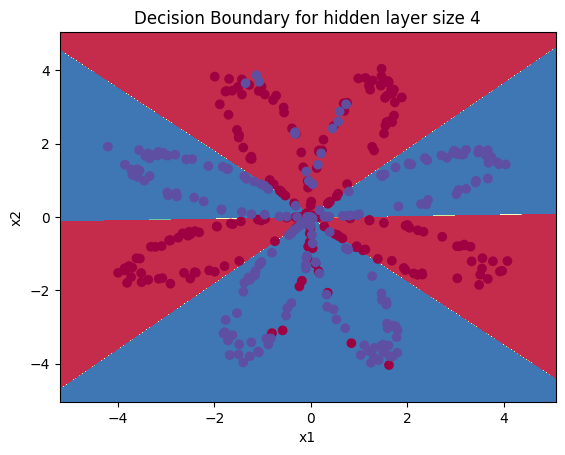

In [24]:
parameters = nn_model(X, Y, n_h = 4, num_iterations=100000, print_cost=True)

#绘制边界
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.ravel())
plt.title("Decision Boundary for hidden layer size " + str(4))

predictions = predict(parameters, X)
print ('准确率: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

### 3.7 更改神经网络隐藏层节点数量
我们上面的实验把隐藏层定为4个节点，现在我们更改隐藏层里面的节点数量，看一看节点数量是否会对结果造成影响。

隐藏层的节点数量： 1  ，准确率: 67.25 %
隐藏层的节点数量： 2  ，准确率: 66.5 %
隐藏层的节点数量： 3  ，准确率: 89.25 %
隐藏层的节点数量： 4  ，准确率: 90.0 %
隐藏层的节点数量： 5  ，准确率: 89.75 %
隐藏层的节点数量： 20  ，准确率: 90.0 %
隐藏层的节点数量： 50  ，准确率: 89.75 %


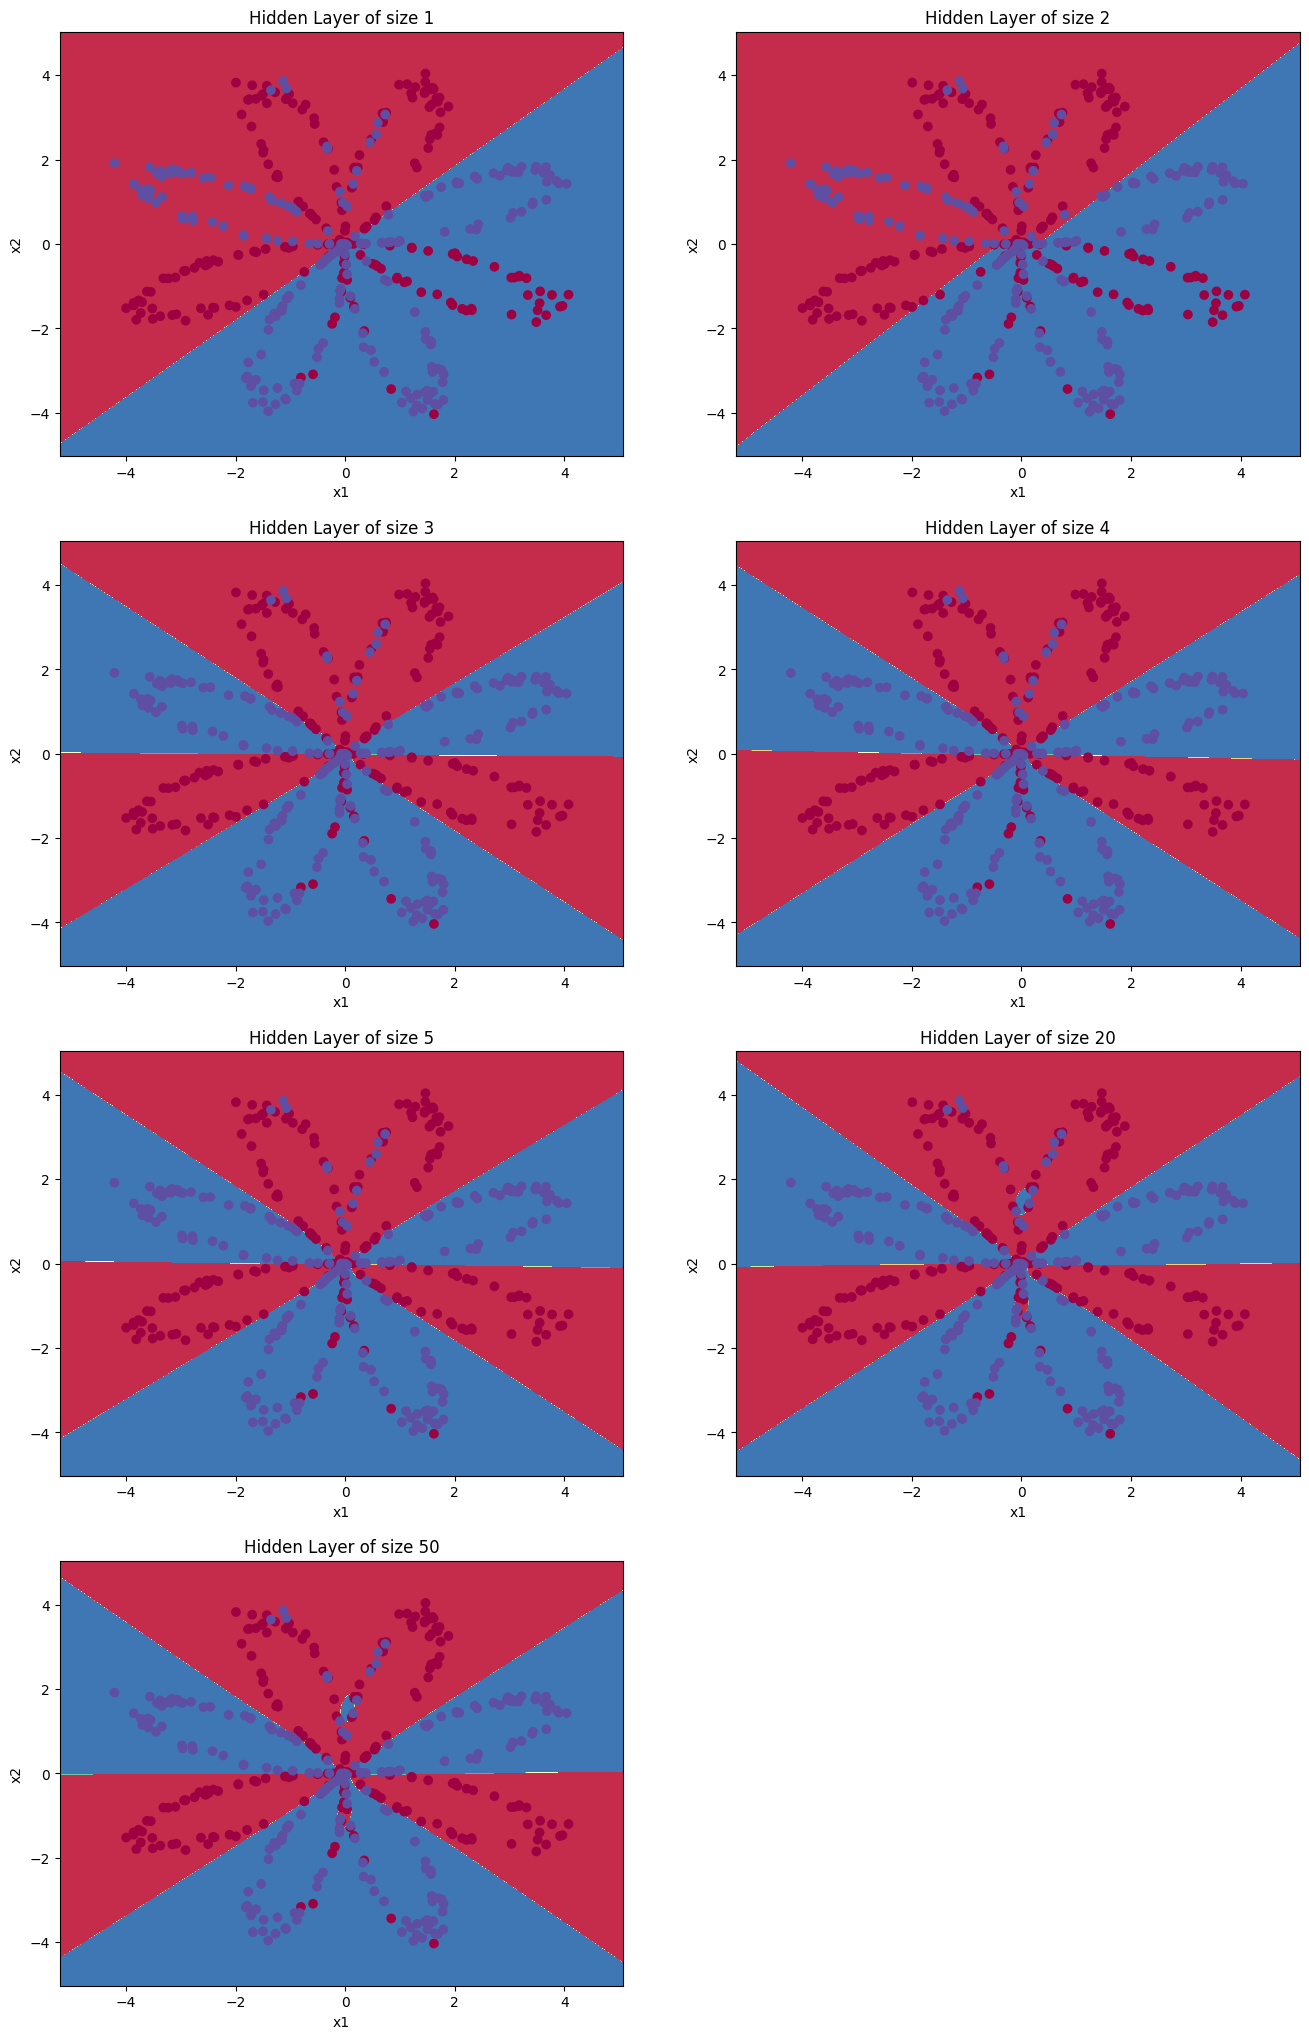

In [26]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50] #隐藏层数量
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations=5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.ravel())
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
    print ("隐藏层的节点数量： {}  ，准确率: {} %".format(n_h, accuracy))